In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import torch

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# 1 Find the division points

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_dir = 'drive/MyDrive/neuro2voc/task_1/'
# data_dir = '/home/zubat/Fei/Task_1/data/'
# output_dir = '/home/zubat/Fei/Task_1/outputs/'

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

Using device: cpu



In [5]:
spike_files_df = pd.read_csv(data_dir+'archives/spikefiles.csv')

In [ ]:
spike_files_df

,Var1
0,raw_g0_t0.nidq.bin
1,raw_g0_t0.nidq.bin
2,raw_g0_t0.nidq.bin
3,raw_g0_t0.nidq.bin
4,raw_g0_t0.nidq.bin
...,...
13237835,raw_g2_t0.nidq.bin
13237836,raw_g2_t0.nidq.bin
13237837,raw_g2_t0.nidq.bin
13237838,raw_g2_t0.nidq.bin


In [6]:
# change_indices = []
# previous_file_name = all_unique_file_names[0]

# for i in range(1, len(spike_files_df)):
#     currentValue = spike_files_df['Var1'][i]
#     if currentValue != previous_file_name:
#         change_indices.append(i)
#         previous_file_name = currentValue

# print("Indices where data changes:", change_indices)

change_indices = [3318179, 8217188]

# 2 Load the spike times

Input: 1. spike times python file that's concatenated together 2. sampling rate


Output: 1. divided into different files (if previous > later, then new file) 2. turning sampling points to ms

In [9]:
def split_spike_samples(spike_samples_concatenated, change_indices):
    spike_samples_splitted = []
    # first
    spike_samples_splitted.append(spike_samples_concatenated[:change_indices[0]])

    # middle, actually only one here
    for i in range(1, len(change_indices)):
        spike_samples_splitted.append(spike_samples_concatenated[change_indices[i-1]:change_indices[i]])

    # last
    spike_samples_splitted.append(spike_samples_concatenated[change_indices[-1]:])

    return spike_samples_splitted

In [10]:
spike_samples = np.load(data_dir+'archives/spiketimes.npy')
spike_samples_splitted = split_spike_samples(spike_samples[0], change_indices) # this is in seconds

# 3 Load the spike clusters

In [7]:
def split_spike_clusters(spike_clusters_concatenated, change_indices):
    split_spike_clusters = []

    # first
    split_spike_clusters.append(spike_clusters_concatenated[:change_indices[0]])

    # middle, actually only one here
    for i in range(1, len(change_indices)):
        split_spike_clusters.append(spike_clusters_concatenated[change_indices[i-1]:change_indices[i]])

    # last
    split_spike_clusters.append(spike_clusters_concatenated[change_indices[-1]:])

    return split_spike_clusters

In [11]:
spike_cluster = np.load(data_dir+'archives/spikecluster.npy')

spike_clusters_splitted = split_spike_clusters(spike_cluster[0], change_indices)
# print('there are', len(spike_clusters_splitted), 'splits')
# print(spike_clusters_splitted[0][0])
# print(spike_clusters_splitted[0][-1])
# print(spike_clusters_splitted[1][0])
# print(spike_clusters_splitted[1][-1])
# print(spike_clusters_splitted[2][1])
# print(spike_clusters_splitted[2][-1])
len(spike_clusters_splitted[0]) == len(spike_samples_splitted[0]) and len(spike_clusters_splitted[1]) == len(spike_samples_splitted[1]) and len(spike_clusters_splitted[2]) == len(spike_samples_splitted[2])

True

# 4 Map neurons to indices

In [12]:
all_unique_values_1 = np.unique(spike_clusters_splitted[0])
all_unique_values_2 = np.unique(spike_clusters_splitted[1])
all_unique_values_3 = np.unique(spike_clusters_splitted[2])
np.array_equal(all_unique_values_1, all_unique_values_2) and np.array_equal(all_unique_values_1, all_unique_values_3)

True

In [13]:
cluster_info_df = pd.read_csv(data_dir+'archives/cluster_info.tsv', sep='\t')
# total_fr = cluster_info_df['fr'].sum()
# print("Total sum of 'fr' column:", total_fr)
num_neurons = len(cluster_info_df)
print("There are", num_neurons, "neurons in total, but only", len(all_unique_values_1), "neurons fired.")

There are 104 neurons in total, but only 75 neurons fired.


In [14]:
neuron_names = all_unique_values_1.tolist()
neuron2idx = {name: idx for idx, name in enumerate(neuron_names)}
print("Neuron name : Index \n ", neuron2idx)
print("\nThe keys are in", type(all_unique_values_1[1]))

Neuron name : Index 
  {12.0: 0, 19.0: 1, 20.0: 2, 21.0: 3, 25.0: 4, 27.0: 5, 31.0: 6, 34.0: 7, 35.0: 8, 36.0: 9, 38.0: 10, 39.0: 11, 40.0: 12, 41.0: 13, 44.0: 14, 45.0: 15, 46.0: 16, 47.0: 17, 48.0: 18, 49.0: 19, 50.0: 20, 51.0: 21, 52.0: 22, 54.0: 23, 55.0: 24, 56.0: 25, 57.0: 26, 58.0: 27, 59.0: 28, 60.0: 29, 61.0: 30, 63.0: 31, 64.0: 32, 65.0: 33, 66.0: 34, 67.0: 35, 68.0: 36, 69.0: 37, 72.0: 38, 73.0: 39, 81.0: 40, 85.0: 41, 92.0: 42, 106.0: 43, 107.0: 44, 109.0: 45, 110.0: 46, 111.0: 47, 284.0: 48, 287.0: 49, 291.0: 50, 293.0: 51, 298.0: 52, 307.0: 53, 311.0: 54, 315.0: 55, 319.0: 56, 326.0: 57, 327.0: 58, 330.0: 59, 346.0: 60, 356.0: 61, 370.0: 62, 377.0: 63, 385.0: 64, 389.0: 65, 396.0: 66, 401.0: 67, 403.0: 68, 406.0: 69, 411.0: 70, 416.0: 71, 419.0: 72, 425.0: 73, 428.0: 74}

The keys are in <class 'numpy.float64'>


In [15]:
cluster_info_df

,id,Amplitude,ContamPct,KSLabel,amp,ch,depth,fr,group,n_spikes,sh
0,5,39.8,49.8,mua,3.339661,31,320,0.269240,mua,3450,0
1,8,27.1,171.7,mua,2.011719,39,400,3.357623,noise,43024,0
2,12,71.5,2.9,good,6.398156,65,660,72.496604,good,928959,0
3,19,66.7,29.7,mua,5.457253,130,1320,33.100882,mua,424149,0
4,20,67.9,38.6,mua,5.524565,130,1320,29.444988,mua,377303,0
...,...,...,...,...,...,...,...,...,...,...,...
99,416,156.0,9.9,good,8.118336,234,2360,7.763722,good,99483,0
100,419,156.5,47.2,mua,8.467825,269,2700,9.385252,mua,120261,0
101,425,59.4,39.7,mua,4.394039,281,2820,6.028409,mua,77247,0
102,428,57.1,20.8,mua,4.542483,337,3380,5.999456,mua,76876,0


In [16]:
unique_ids = cluster_info_df['id'].unique()
difference = set(unique_ids) - set(all_unique_values_1)
difference

{5,
 8,
 22,
 24,
 70,
 75,
 77,
 78,
 82,
 83,
 84,
 88,
 89,
 90,
 93,
 94,
 97,
 98,
 99,
 100,
 101,
 105,
 114,
 259,
 305,
 350,
 398,
 399,
 429}

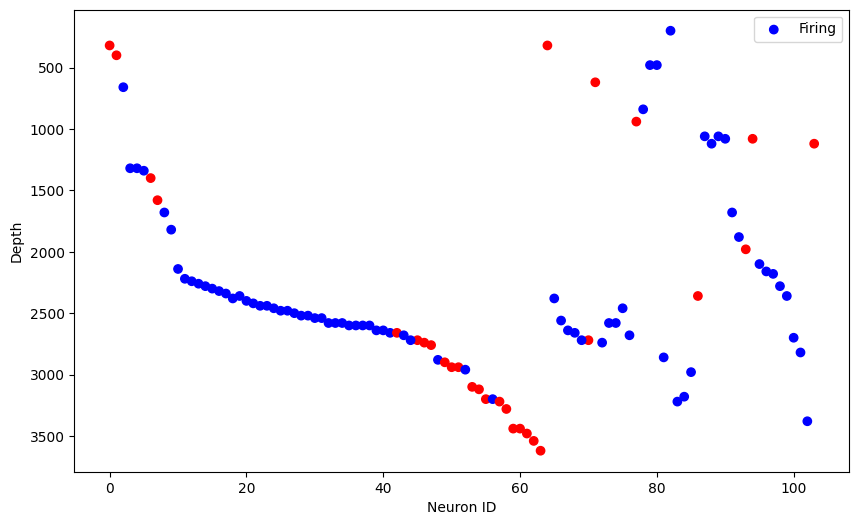

In [17]:
import matplotlib.pyplot as plt

sorted_df = cluster_info_df.sort_values('depth', ascending=True)
colors = ['red' if id in difference else 'blue' for id in sorted_df['id']]

plt.figure(figsize=(10, 6))
plt.scatter(sorted_df.index, sorted_df['depth'], c=colors, label='Neuron Depth')
plt.gca().invert_yaxis()
plt.xlabel('Neuron ID')
plt.ylabel('Depth')
plt.legend(['Firing', 'Non-firing'])
plt.show()


In [18]:
cluster_info_df['fired'] = ~cluster_info_df['id'].isin(difference)
firing_summary = cluster_info_df.groupby(['group', 'fired']).size().unstack(fill_value=0)
print(firing_summary)

fired  False  True 
group              
good       0     18
mua        2     57
noise     27      0


In [19]:
non_firing_mua_neuron_ids = cluster_info_df[(cluster_info_df['group'] == 'mua') &
                                            (cluster_info_df['id'].isin(difference))]

non_firing_mua_neuron_ids

,id,Amplitude,ContamPct,KSLabel,amp,ch,depth,fr,group,n_spikes,sh,fired
0,5,39.8,49.8,mua,3.339661,31,320,0.269240,mua,3450,0,False
42,70,123.6,133.3,mua,9.558495,265,2660,0.135245,mua,1733,0,False


In [20]:
def get_x_position(channel):
    """
    Returns x position based on channel number
    For Neuropixel 1.0, sites are in a checkerboard pattern
    """
    return 32 if channel % 2 else 0

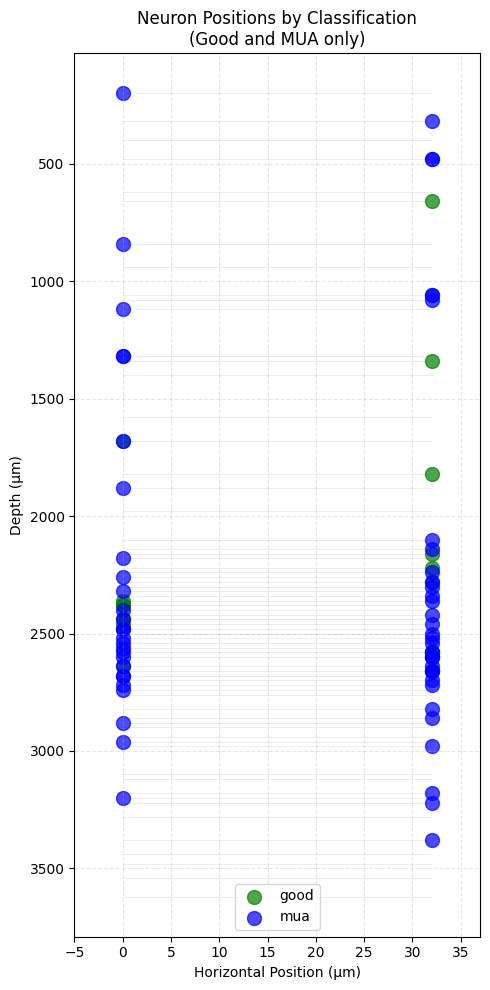


Neuron Classification Summary (Good and MUA only):
group
good    18
mua     59
dtype: int64

Example of recording site depths and channels:
    depth  ch
82    200  18
0     320  31
64    320  30
1     400  39
80    480  47
79    480  47
71    620  61
2     660  65
78    840  82
77    940  93


In [21]:
# Sort DataFrame by depth
sorted_df = cluster_info_df.sort_values('depth', ascending=True)

# Create the plot
plt.figure(figsize=(5, 10))

# Plot only good and mua groups
colors = {'good': 'green', 'mua': 'blue'}



# Add small arrows or lines to show pairs of recording sites
for depth in sorted_df['depth'].unique():
    plt.plot([0, 32], [depth, depth], 'k-', alpha=0.1, linewidth=0.5)

for group in colors:
    mask = sorted_df['group'] == group
    group_df = sorted_df[mask]
    x_positions = group_df['ch'].apply(get_x_position)

    plt.scatter(x_positions,
               group_df['depth'],
               c=colors[group],
               label=group,
               alpha=0.7,
               s=100)

# Customize the plot
plt.gca().invert_yaxis()
plt.xlabel('Horizontal Position (μm)')
plt.ylabel('Depth (μm)')
plt.title('Neuron Positions by Classification\n(Good and MUA only)')

# Set x-axis limits
plt.xlim(-5, 37)

# Add grid
plt.grid(True, linestyle='--', alpha=0.3)

# Add legend
plt.legend()

plt.tight_layout()
plt.show()

# Print summary of only good and mua
group_summary = sorted_df[sorted_df['group'].isin(['good', 'mua'])].groupby('group').size()
print("\nNeuron Classification Summary (Good and MUA only):")
print(group_summary)

# Print some example depths to show the pattern
print("\nExample of recording site depths and channels:")
print(sorted_df[['depth', 'ch']].head(10))

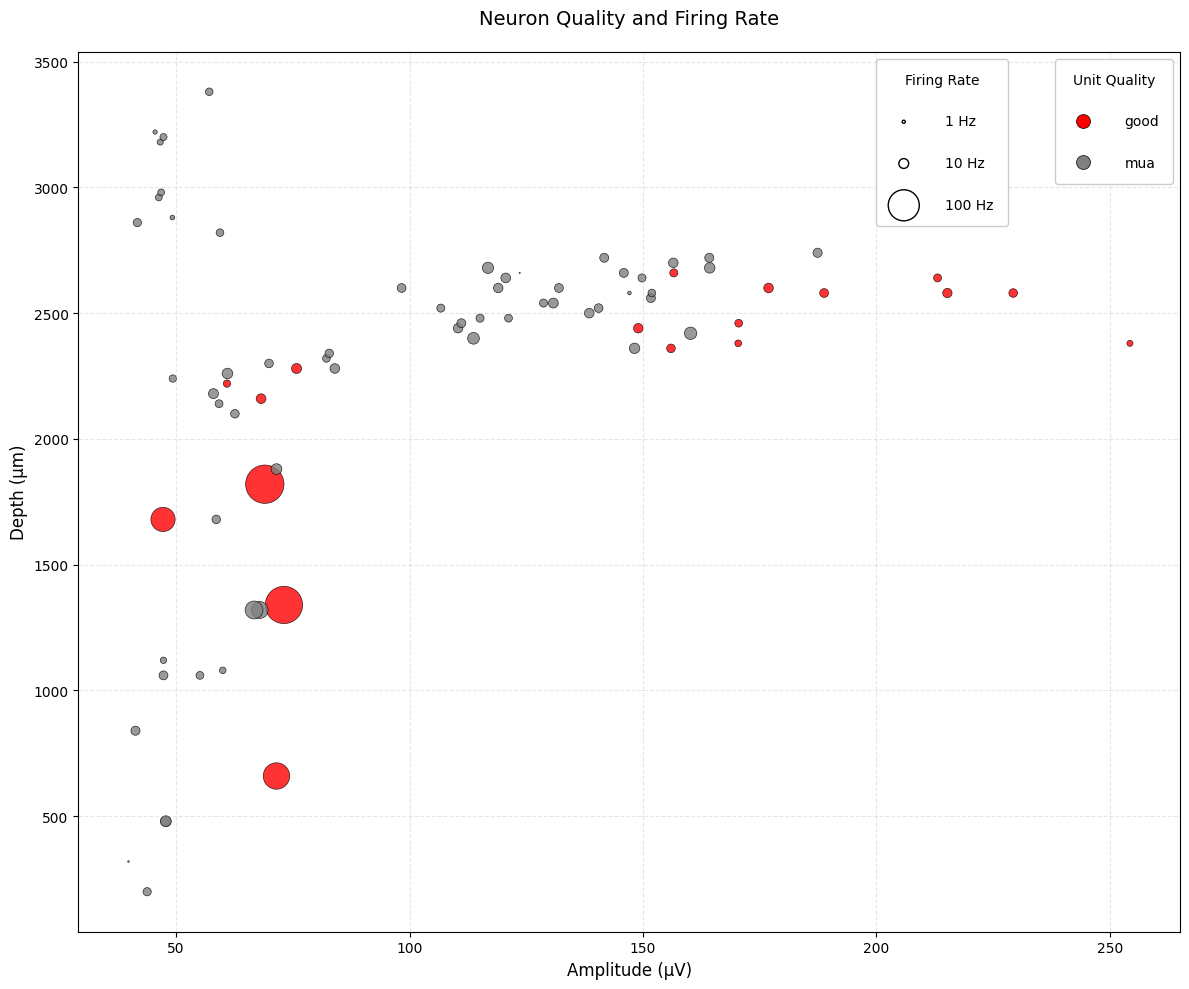


Neuron Classification Summary (Good and MUA only):
group
good    18
mua     59
dtype: int64


In [24]:
# Sort DataFrame by depth
sorted_df = cluster_info_df.sort_values('depth', ascending=True)

# Create the plot with a wider aspect ratio
plt.figure(figsize=(12, 10))

# Plot only good and mua groups with different colors and sizes
colors = {'good': 'red', 'mua': 'gray'}

for group in colors:
    mask = sorted_df['group'] == group
    group_df = sorted_df[mask]

    plt.scatter(group_df['Amplitude'],  # Changed back to Amplitude
               group_df['depth'],
               c=colors[group],
               s=group_df['fr'] * 5,
               label=group,
               alpha=0.8,
               edgecolors='black',
               linewidth=0.5)

# Customize the plot
plt.xlabel('Amplitude (μV)', fontsize=12)  # Changed back to Amplitude
plt.ylabel('Depth (μm)', fontsize=12)
plt.title('Neuron Quality and Firing Rate', fontsize=14, pad=20)

# Add grid with better styling
plt.grid(True, linestyle='--', alpha=0.3, which='both')

# Create two separate legend columns
quality_legend = [plt.Line2D([0], [0], marker='o', color='w',
                           markerfacecolor=color, label=group,
                           markersize=10, markeredgecolor='black',
                           markeredgewidth=0.5)
                 for group, color in colors.items()]

rate_legend = [plt.scatter([], [], c='none', edgecolors='black',
                         s=(size * 5), label=f'{size} Hz')
               for size in [1, 10, 100]]

# Create legend with two columns
first_legend = plt.legend(handles=quality_legend,
                         title='Unit Quality',
                         loc='upper right',
                         bbox_to_anchor=(1, 1),
                         title_fontsize=10,
                         framealpha=1,
                         handletextpad=2,
                         borderpad=1,
                         labelspacing=2)

# Add the second legend with more space
plt.gca().add_artist(first_legend)
plt.legend(handles=rate_legend,
          title='Firing Rate',
          loc='upper right',
          bbox_to_anchor=(0.85, 1),
          title_fontsize=10,
          framealpha=1,
          handletextpad=2,
          borderpad=1,
          labelspacing=2)

# Add tick parameters
plt.tick_params(axis='both', which='major', labelsize=10)

# Adjust layout
plt.tight_layout()

# Save the plot as PDF
plt.savefig('neuron_quality.pdf', bbox_inches='tight', dpi=300)  # Changed filename back
plt.show()

# Print summary of only good and mua
group_summary = sorted_df[sorted_df['group'].isin(['good', 'mua'])].groupby('group').size()
print("\nNeuron Classification Summary (Good and MUA only):")
print(group_summary)

<ipython-input-56-f8c9e5172498>:21: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=colormap))


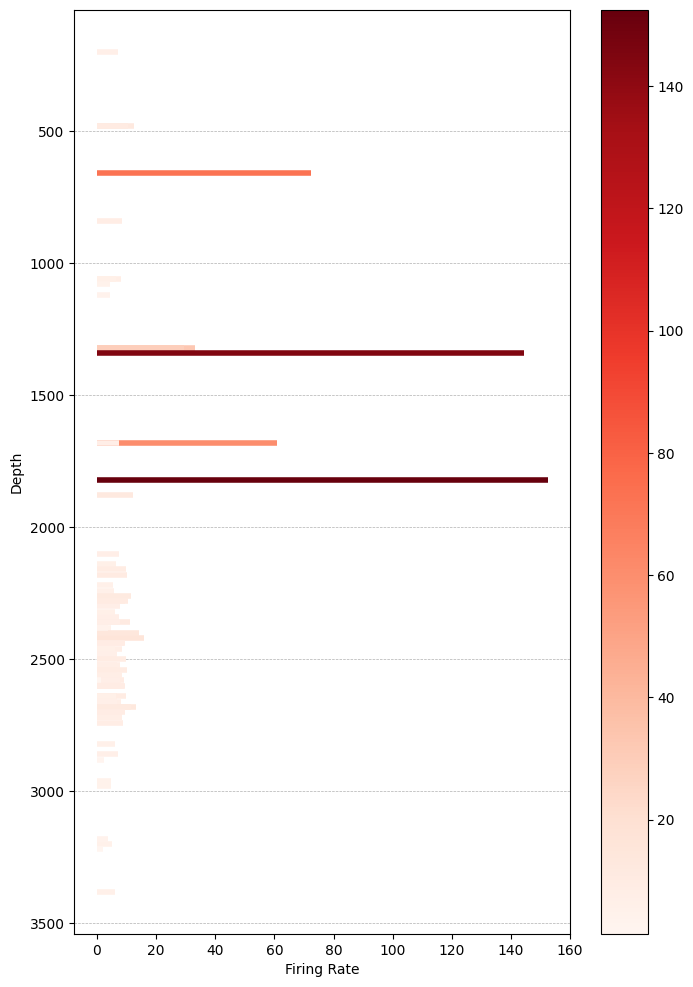

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

fired_neurons = cluster_info_df[~cluster_info_df['id'].isin(difference)]

plt.figure(figsize=(8, 12))

colormap = plt.cm.Reds

norm = colors.Normalize(vmin=fired_neurons['fr'].min(), vmax=fired_neurons['fr'].max())

for idx, row in fired_neurons.iterrows():
    plt.hlines(
        y=row['depth'],
        xmin=0,
        xmax=row['fr'],
        color=colormap(norm(row['fr'])),
        linewidth=4
    )

plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=colormap))

# Labeling the axes
plt.xlabel('Firing Rate')
plt.ylabel('Depth')

plt.gca().invert_yaxis()

plt.grid(True, which='both', linestyle='--', linewidth=0.5, axis='y')
plt.show()


In [ ]:
fr_sorted_df = cluster_info_df.sort_values('fr', ascending=False)
fr_sorted_df

,id,Amplitude,ContamPct,KSLabel,amp,ch,depth,fr,group,n_spikes,sh,fired
9,27,69.0,1.0,good,6.392597,181,1820,152.460532,good,1953603,0,True
5,21,73.1,1.3,good,7.051258,133,1340,144.391748,good,1850211,0,True
2,12,71.5,2.9,good,6.398156,65,660,72.496604,good,928959,0,True
8,25,47.2,9.3,good,5.122686,166,1680,60.832564,good,779498,0,True
71,259,41.1,419.9,mua,2.839535,61,620,38.318448,noise,491006,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...
0,5,39.8,49.8,mua,3.339661,31,320,0.269240,mua,3450,0,False
86,350,297.4,183.1,mua,4.617359,235,2360,0.243253,noise,3117,0,False
42,70,123.6,133.3,mua,9.558495,265,2660,0.135245,mua,1733,0,False
94,399,71.5,20.2,mua,4.389317,107,1080,0.105589,noise,1353,0,False


# 5 Load the label

In [ ]:
annotations_df = pd.read_csv(data_dir+'archives/annotations.csv')
annotations_df

,file,onset,duration,cluster_id
0,raw_g0_t0.nidq.bin,4096.00,0.00,1
1,raw_g0_t0.nidq.bin,6654369.00,774.00,10
2,raw_g0_t0.nidq.bin,6799068.00,1061.00,10
3,raw_g0_t0.nidq.bin,7433497.51,80000.68,13
4,raw_g0_t0.nidq.bin,8136840.51,80000.68,13
...,...,...,...,...
3701,raw_g2_t0.nidq.bin,82353205.00,3172.00,3
3702,raw_g2_t0.nidq.bin,82356377.00,1525.00,4
3703,raw_g2_t0.nidq.bin,82357902.00,2568.00,5
3704,raw_g2_t0.nidq.bin,83287965.00,2003.00,10


In [ ]:
# choose only syllables
syllable_annotations_df = annotations_df[annotations_df['cluster_id'].isin(range(2, 10))].copy()
# in bins, in 1ms resolution
# syllable_annotations_df['onset_bin'] = (1000*(syllable_annotations_df['onset'] / 20000)).astype(int)
# syllable_annotations_df['duration_bin'] = (1000*(syllable_annotations_df['duration'] / 20000)).astype(int)

syllable_annotations_df

,file,onset,duration,cluster_id
15,raw_g0_t0.nidq.bin,15521214.0,986.0,2
16,raw_g0_t0.nidq.bin,15525652.0,979.0,2
17,raw_g0_t0.nidq.bin,15576333.0,929.0,2
18,raw_g0_t0.nidq.bin,15583214.0,991.0,2
19,raw_g0_t0.nidq.bin,15588407.0,2960.0,3
...,...,...,...,...
3699,raw_g2_t0.nidq.bin,82347286.0,666.0,6
3700,raw_g2_t0.nidq.bin,82348589.0,3939.0,7
3701,raw_g2_t0.nidq.bin,82353205.0,3172.0,3
3702,raw_g2_t0.nidq.bin,82356377.0,1525.0,4


In [ ]:
# Assuming syllable_annotations_df is your DataFrame containing the data
# Count the distribution of cluster_id values
cluster_id_distribution = syllable_annotations_df['cluster_id'].value_counts()

# Print or display the distribution
print(cluster_id_distribution)


cluster_id
3    638
4    626
5    623
7    554
6    541
2    472
8      5
Name: count, dtype: int64


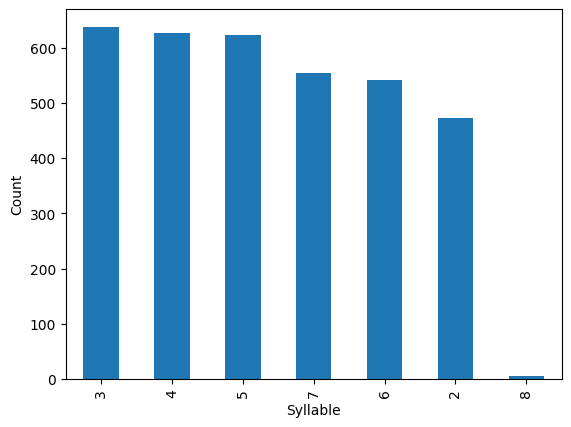

In [ ]:
import matplotlib.pyplot as plt
cluster_id_distribution.plot(kind='bar', xlabel='Syllable', ylabel='Count')
plt.show()


In [ ]:
# Ensure the DataFrame is correctly indexed
syllable_annotations_df.reset_index(drop=True, inplace=True)

# Function to count increasing number sequences
def count_increasing_sequences(data):
    sequences_count = {}
    current_sequence = 1

    for i in range(1, len(data)):
        if data[i] == data[i-1] + 1:
            current_sequence += 1
        else:
            if current_sequence > 1:
                sequences_count.setdefault(current_sequence, 0)
                sequences_count[current_sequence] += 1
            current_sequence = 1

    if current_sequence > 1:
        sequences_count.setdefault(current_sequence, 0)
        sequences_count[current_sequence] += 1

    return sequences_count

# Count increasing sequences
sequences_count = count_increasing_sequences(syllable_annotations_df['cluster_id'])

print("Counts of increasing sequences:", sequences_count)


Counts of increasing sequences: {6: 211, 3: 74, 5: 323, 4: 16, 2: 6}


In [ ]:
# Function to count increasing number sequences
def count_increasing_sequences(data):
    sequences_count = {}
    current_sequence = []

    for num in data:
        if not current_sequence or num == current_sequence[-1] + 1:
            current_sequence.append(num)
        else:
            if len(current_sequence) > 1:
                sequence_key = tuple(current_sequence)
                sequences_count.setdefault(sequence_key, 0)
                sequences_count[sequence_key] += 1
            current_sequence = [num]

    if len(current_sequence) > 1:
        sequence_key = tuple(current_sequence)
        sequences_count.setdefault(sequence_key, 0)
        sequences_count[sequence_key] += 1

    return sequences_count

# Count increasing sequences
sequences_count = count_increasing_sequences(syllable_annotations_df['cluster_id'])

print("Counts of increasing sequences:", sequences_count)


Counts of increasing sequences: {(2, 3, 4, 5, 6, 7): 211, (3, 4, 5): 73, (3, 4, 5, 6, 7): 322, (2, 3, 4, 5): 11, (3, 4, 5, 6): 3, (2, 3, 4, 5, 6): 1, (2, 3, 4): 1, (6, 7): 2, (3, 4): 2, (4, 5, 6, 7): 2, (2, 3): 2}


In [ ]:
# Function to count increasing number sequences
def count_increasing_sequences(data):
    sequences_count = {}
    current_sequence = []

    for num in data:
        if not current_sequence or num == current_sequence[-1] + 1:
            current_sequence.append(num)
        else:
            if current_sequence:
                sequence_key = tuple(current_sequence)
                sequences_count.setdefault(sequence_key, 0)
                sequences_count[sequence_key] += 1
            current_sequence = [num]

    if current_sequence:
        sequence_key = tuple(current_sequence)
        sequences_count.setdefault(sequence_key, 0)
        sequences_count[sequence_key] += 1

    return sequences_count

# Count increasing sequences
sequences_count = count_increasing_sequences(syllable_annotations_df['cluster_id'])

print("Counts of increasing sequences:", sequences_count)


Counts of increasing sequences: {(2,): 246, (2, 3, 4, 5, 6, 7): 211, (3, 4, 5): 73, (3, 4, 5, 6, 7): 322, (2, 3, 4, 5): 11, (7,): 17, (3, 4, 5, 6): 3, (3,): 12, (2, 3, 4, 5, 6): 1, (2, 3, 4): 1, (6, 7): 2, (3, 4): 2, (8,): 5, (4, 5, 6, 7): 2, (2, 3): 2}


In [ ]:
# Find where 8 occurs in the 'cluster_id' column
indices_of_8 = syllable_annotations_df.index[syllable_annotations_df['cluster_id'] == 8].tolist()

# Extract the context of 8
context_of_8 = []
for index in indices_of_8:
    context = syllable_annotations_df.iloc[max(0, index - 2):min(len(syllable_annotations_df), index + 3)]
    context_of_8.append(context)

# Display the context of 8
for i, context in enumerate(context_of_8, 1):
    print(f"Context {i} of 8:")
    print(context)
    print("\n")


Context 1 of 8:
                    file       onset  duration  cluster_id
1681  raw_g2_t0.nidq.bin  25182346.0    3977.0           7
1682  raw_g2_t0.nidq.bin  25188289.0    1143.0           2
1683  raw_g2_t0.nidq.bin  25199164.0    1559.0           8
1684  raw_g2_t0.nidq.bin  25202186.0    2141.0           8
1685  raw_g2_t0.nidq.bin  25204618.0    1365.0           4


Context 2 of 8:
                    file       onset  duration  cluster_id
1682  raw_g2_t0.nidq.bin  25188289.0    1143.0           2
1683  raw_g2_t0.nidq.bin  25199164.0    1559.0           8
1684  raw_g2_t0.nidq.bin  25202186.0    2141.0           8
1685  raw_g2_t0.nidq.bin  25204618.0    1365.0           4
1686  raw_g2_t0.nidq.bin  25206143.0    2328.0           5


Context 3 of 8:
                    file       onset  duration  cluster_id
1763  raw_g2_t0.nidq.bin  28602708.0     975.0           2
1764  raw_g2_t0.nidq.bin  28616660.0     892.0           2
1765  raw_g2_t0.nidq.bin  28618795.0    2335.0           8
1766

In [ ]:
annotations_df_1 = syllable_annotations_df[syllable_annotations_df['file'] == 'raw_g0_t0.nidq.bin']
annotations_df_2 = syllable_annotations_df[syllable_annotations_df['file'] == 'raw_g1_t0.nidq.bin']
annotations_df_3 = syllable_annotations_df[syllable_annotations_df['file'] == 'raw_g2_t0.nidq.bin']

In [ ]:
annotations_df_1

# 6 Extract the data

### First remove the duplicates

In [ ]:
def remove_duplicates(df, time_increment=1):
    # sort df
    df = df.sort_values(by='onset').reset_index(drop=True)

    # loop except last one
    for i in range(len(df) - 1):
        # calculate the offset of current row
        current_offset = df.at[i, 'onset'] + df.at[i, 'duration']

        # check for any duplicates with next onset
        if current_offset >= df.at[i + 1, 'onset']:
            # time increment ensures that there is no identical values
            df.at[i, 'duration'] = df.at[i + 1, 'onset'] - df.at[i, 'onset'] - time_increment

    return df

In [ ]:
annotations_df_1 = remove_duplicates(annotations_df_1)
annotations_df_2 = remove_duplicates(annotations_df_2)
annotations_df_3 = remove_duplicates(annotations_df_3)

In [ ]:
annotations_df_1.to_csv(output_dir+'clean_annotations_df_1', index=False)
annotations_df_2.to_csv(output_dir+'clean_annotations_df_2', index=False)
annotations_df_3.to_csv(output_dir+'clean_annotations_df_3', index=False)

### Then extract and clean it

In [ ]:
def extract_and_clean_data(spike_samples, spike_clusters, annotation_df, neuron2idx, directory, filename):
    extracted_data = []

    # loop thru each row in annotation_df
    for _, row in tqdm(annotation_df.iterrows(), total=annotation_df.shape[0], desc="Extracting..."):
        onset, duration, label = row['onset'], row['duration'], row['cluster_id']
        end_time = onset + duration

        # enumerate spike samples
        # try to find indices of timepoints that fall in the period
        indices = [i for i, sample in enumerate(spike_samples) if onset <= sample < end_time]

        # use the indices to extract the time (sample) and place of spikes
        # Method 1:
        # extracted_data.append({'samples': samples, 'clusters': clusters, 'label': label})
        # Method 2: individually
        for i in indices:
            sample = spike_samples[i]
            cluster = spike_clusters[i]
            sample_round = round(sample)
            idx = neuron2idx.get(int(cluster), None)

            if idx is not None:
                extracted_data.append({'sample': sample, 'sample_round': sample_round, 'cluster': cluster, 'idx': idx, 'label': label})
            else:
                print(f"Warning: Cluster {cluster}, type{type(cluster)} not found in mapping.")

    # saving
    df = pd.DataFrame(extracted_data)
    csv_file_path = f"{directory}/{filename}"
    df.to_csv(csv_file_path, index=False)
    print(f"Data saved to {csv_file_path}")

    return df

# Call the function with appropriate parameters
# Example: result_df = extract_and_clean_data(spike_samples, spike_clusters, annotations_df, neuron2idx, 'directory_path', 'filename.csv')


In [ ]:
paired_data_1 = extract_and_clean_data(spike_samples_splitted[0], spike_clusters_splitted[0], annotations_df_1, neuron2idx, data_dir, 'extracted_data_1.csv')

Extracting...: 100%|██████████| 417/417 [05:19<00:00,  1.31it/s]


Data saved to drive/MyDrive/neuro2voc_data/task_1//extracted_data_1.csv


In [ ]:
paired_data_2 = extract_and_clean_data(spike_samples_splitted[1], spike_clusters_splitted[1], annotations_df_2, neuron2idx, data_dir, 'extracted_data_2.csv')

Extracting...: 100%|██████████| 191/191 [02:53<00:00,  1.10it/s]


Data saved to drive/MyDrive/neuro2voc_data/task_1//extracted_data_2.csv


In [ ]:
paired_data_3 = extract_and_clean_data(spike_samples_splitted[2], spike_clusters_splitted[2], annotations_df_3, neuron2idx, data_dir, 'extracted_data_3.csv')

Extracting...: 100%|██████████| 2851/2851 [48:23<00:00,  1.02s/it]


Data saved to drive/MyDrive/neuro2voc_data/task_1//extracted_data_3.csv


### Then Check duplicates again


In [ ]:
def check_duplicate_clusters_and_samples(df):
    duplicate_rows = df.duplicated(subset=['cluster', 'sample_round'], keep=False)
    num_duplicates = duplicate_rows.sum()

    if num_duplicates > 0:
        print(f"There are {num_duplicates} cases where both cluster and sample_round are the same.")
        return df[duplicate_rows]
    else:
        print("There are no cases where both cluster and sample_round are the same.")
        return None

In [ ]:
duplicate_cases_df_1 = check_duplicate_clusters_and_samples(paired_data_1)

There are no cases where both cluster and sample_round are the same.


In [ ]:
duplicate_cases_df_2 = check_duplicate_clusters_and_samples(paired_data_2)

There are no cases where both cluster and sample_round are the same.


In [ ]:
duplicate_cases_df_3 = check_duplicate_clusters_and_samples(paired_data_3)

There are 8 cases where both cluster and sample_round are the same.


In [ ]:
duplicate_cases_df_3

,sample,sample_round,cluster,idx,label
296489,2.930544e+07,29305442,12.0,0,7
296490,2.930544e+07,29305442,12.0,0,7
481797,4.952714e+07,49527139,293.0,51,7
481798,4.952714e+07,49527139,293.0,51,7
504292,5.052288e+07,50522876,19.0,1,3
504293,5.052288e+07,50522876,19.0,1,3
597609,5.790834e+07,57908342,21.0,3,5
597610,5.790834e+07,57908342,21.0,3,5
